In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem import Truss
from torchfem.materials import IsotropicElasticity1D

plt.rcParams["text.usetex"] = True

torch.set_default_dtype(torch.double)

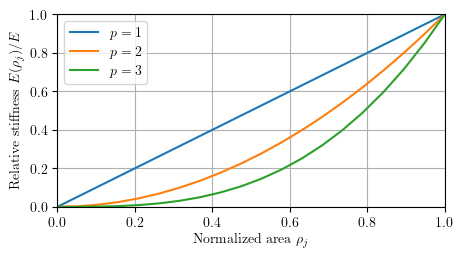

In [2]:
p = 3
Cxx = 1.0

# Plot the SIMP relation
rho = torch.linspace(0, 1, 20)
plt.figure(figsize=(5, 2.5))
plt.plot(rho, Cxx * rho**1.0, label="$p=1$")
plt.plot(rho, Cxx * rho**2.0, label="$p=2$")
plt.plot(rho, Cxx * rho**3.0, label="$p=3$")
plt.xlabel(r"$\textrm{Normalized area } \rho_j$")
plt.ylabel(r"$\textrm{Relative stiffness } E(\rho_j) / E$")
plt.xlim([0, 1])
plt.ylim([0, Cxx])
plt.legend()
plt.grid()
plt.savefig("../figures/simp_truss.svg", transparent=True, bbox_inches="tight")

# Sample truss

In [3]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = torch.tensor(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 4],
        [5, 6],
        [6, 7],
        [7, 8],
        [8, 9],
        [1, 5],
        [0, 6],
        [2, 6],
        [1, 7],
        [3, 7],
        [2, 8],
        [4, 8],
        [3, 9],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9],
    ]
)

material = IsotropicElasticity1D(1.0)

truss_sample = Truss(nodes, elements, material)

truss_sample.forces[4, 1] = -0.1
truss_sample.constraints[0, 0] = True
truss_sample.constraints[0, 1] = True
truss_sample.constraints[5, 0] = True
truss_sample.areas[:] = 10.0

## The optimization

In [4]:
def newton(grad, mu_init, max_iter=10, tol=0.0001):
    # Newton's method to find root of grad (few iterations, if succesfull)
    mu = torch.tensor([mu_init], requires_grad=True)
    i = 0
    while torch.abs(grad(mu)) > tol:
        if i > max_iter:
            raise Exception(f"Newton solver did not converge in {max_iter} iterations.")
        gradgrad = torch.autograd.grad(grad(mu).sum(), mu)[0]
        mu.data -= grad(mu) / gradgrad
        mu.data = torch.max(mu.data, torch.tensor([0.0]))
        i += 1
    return mu.data


def bisection(grad, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if grad(a) * grad(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def compute_lengths(truss):
    start_nodes = truss.nodes[truss.elements[:, 0]]
    end_nodes = truss.nodes[truss.elements[:, 1]]
    dx = end_nodes - start_nodes
    return torch.linalg.norm(dx, dim=-1)


def optimize(truss, a_0, a_min, a_max, V_0, iter=10, s=0.7, p=1.0):
    k0 = truss.k0() / truss.areas[:, None, None]
    a = [a_0]
    L = []
    l = compute_lengths(truss)

    # Check if there is a feasible solution before starting iteration
    if torch.inner(a_min, l) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point a_k
        truss.areas = a[k] * (a[k] / a_max) ** p
        u_k, f_k, _, _, _ = truss.solve()

        # Get strain energy of all truss elements for the given displacement
        disp = u_k[truss.elements].reshape(-1, 4)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * (a[k] / a_max) ** (p - 1) * 2.0 * w_k

        # Compute lower asymptote
        if k <= 1:
            L.append(a[k] - s * (a_max - a_min))
        else:
            L_k = torch.zeros_like(L[k - 1])
            osci = (a[k] - a[k - 1]) * (a[k - 1] - a[k - 2]) < 0.0
            L_k[osci] = a[k][osci] - s * (a[k - 1][osci] - L[k - 1][osci])
            L_k[~osci] = a[k][~osci] - 1 / sqrt(s) * (a[k - 1][~osci] - L[k - 1][~osci])
            L.append(L_k)

        # Compute lower move limit in this step
        a_min_k = torch.max(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution
        def x_star(mu):
            a_hat = L[k] + torch.sqrt((-sensitivity * (L[k] - a[k]) ** 2) / (mu * l))
            return torch.clamp(a_hat, a_min_k, a_max)

        # Analytical gradient
        def grad(mu):
            return torch.dot(x_star(mu), l) - V_0

        # Solve dual problem
        # mu_star = newton(grad, 1.0)
        mu_star = bisection(grad, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        a.append(x_star(mu_star))

    return a

## Topology optimization of the sample truss

Iteration k=0 - Compliance: 1.60058
Iteration k=1 - Compliance: 0.04992
Iteration k=2 - Compliance: 0.04823
Iteration k=3 - Compliance: 0.03525
Iteration k=4 - Compliance: 0.02889
Iteration k=5 - Compliance: 0.02768
Iteration k=6 - Compliance: 0.02768
Iteration k=7 - Compliance: 0.02768
Iteration k=8 - Compliance: 0.02768
Iteration k=9 - Compliance: 0.02768


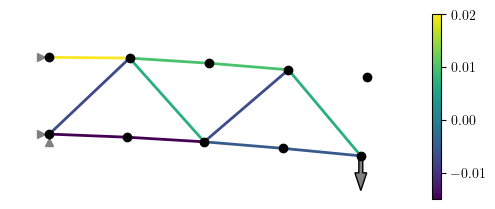

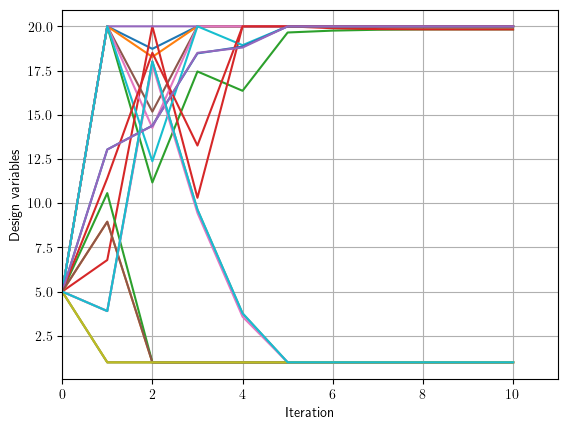

In [5]:
a_0 = 5.0 * torch.ones((len(truss_sample.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)
# Compute volume restriction
l = compute_lengths(truss_sample)
V0 = 0.565 * torch.inner(a_max, l)

a_opt = optimize(truss_sample, a_0, a_min, a_max, V0, iter=10, p=2)
u, f, sigma, _, _ = truss_sample.solve()
truss_sample.plot(
    u=u, element_property=sigma, thickness_threshold=2.0, node_labels=False
)
plt.savefig(
    "../figures/truss_sample_topology_optimized.svg",
    transparent=True,
    bbox_inches="tight",
)
plt.show()

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.show()

## Bridge

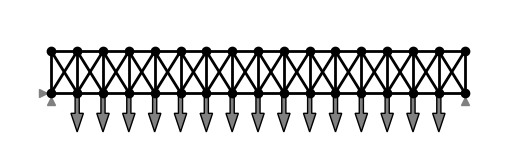

In [6]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
elements = []
for i in range(A - 1):
    for j in range(B):
        elements.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        elements.append([i + j * A, i + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elements.append([i + j * A, i + 1 + A + j * A])
        elements.append([i + 1 + j * A, i + A + j * A])
elements = torch.tensor(elements)

# Material
material = IsotropicElasticity1D(500.0)

# Truss
bridge = Truss(nodes.clone(), elements, material)

# Forces at bottom edge
bridge.forces[1 : A - 1, 1] = -0.1

# Constraints by the supports
bridge.constraints[0, 0] = True
bridge.constraints[0, 1] = True
bridge.constraints[A - 1, 1] = True

# Plot
bridge.plot(node_labels=False)

Iteration k=0 - Compliance: 0.01812
Iteration k=1 - Compliance: 0.02468
Iteration k=2 - Compliance: 0.41196
Iteration k=3 - Compliance: 3.54525
Iteration k=4 - Compliance: 0.48119
Iteration k=5 - Compliance: 0.05083
Iteration k=6 - Compliance: 0.04977
Iteration k=7 - Compliance: 0.07433
Iteration k=8 - Compliance: 0.01339
Iteration k=9 - Compliance: 0.02662
Iteration k=10 - Compliance: 0.04031
Iteration k=11 - Compliance: 0.02164
Iteration k=12 - Compliance: 0.02333
Iteration k=13 - Compliance: 0.01066
Iteration k=14 - Compliance: 0.00909
Iteration k=15 - Compliance: 0.00758
Iteration k=16 - Compliance: 0.00875
Iteration k=17 - Compliance: 0.00767
Iteration k=18 - Compliance: 0.00843
Iteration k=19 - Compliance: 0.00745
Iteration k=20 - Compliance: 0.00688
Iteration k=21 - Compliance: 0.00620
Iteration k=22 - Compliance: 0.00534
Iteration k=23 - Compliance: 0.00493
Iteration k=24 - Compliance: 0.00471
Iteration k=25 - Compliance: 0.00459
Iteration k=26 - Compliance: 0.00446
Iteration k

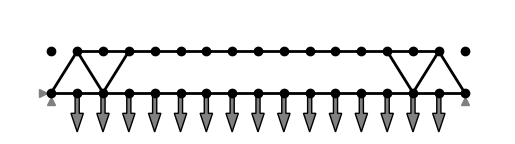

In [7]:
a_0 = 10.0 * torch.ones((len(elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)
l = compute_lengths(bridge)
V0 = 0.43 * torch.inner(a_max, l)

a_opt = optimize(bridge, a_0, a_min, a_max, V0, iter=30, p=2)
bridge.plot(thickness_threshold=2.0, node_labels=False)
plt.savefig(
    "../figures/bridge_topology_optimized.svg", transparent=True, bbox_inches="tight"
)
plt.show()